In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
#spark = sqlContext

In [2]:
advt = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('F:/JupyterML/ML_Practice/datasets/Advertising.csv')

In [3]:
advt.show(4)

+---+-----+-----+---------+-----+
|_c0|   TV|radio|newspaper|sales|
+---+-----+-----+---------+-----+
|  1|230.1| 37.8|     69.2| 22.1|
|  2| 44.5| 39.3|     45.1| 10.4|
|  3| 17.2| 45.9|     69.3|  9.3|
|  4|151.5| 41.3|     58.5| 18.5|
+---+-----+-----+---------+-----+
only showing top 4 rows



In [51]:
advt.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- TV: double (nullable = true)
 |-- radio: double (nullable = true)
 |-- newspaper: double (nullable = true)
 |-- sales: double (nullable = true)



In [52]:
advt = advt.select([col for col in advt.columns if col not in ['_c0']])

In [53]:
advt.show(2)

+-----+-----+---------+-----+
|   TV|radio|newspaper|sales|
+-----+-----+---------+-----+
|230.1| 37.8|     69.2| 22.1|
| 44.5| 39.3|     45.1| 10.4|
+-----+-----+---------+-----+
only showing top 2 rows



In [54]:
advt.cache()

DataFrame[TV: double, radio: double, newspaper: double, sales: double]

In [55]:
advt.describe().show()

+-------+-----------------+------------------+------------------+------------------+
|summary|               TV|             radio|         newspaper|             sales|
+-------+-----------------+------------------+------------------+------------------+
|  count|              200|               200|               200|               200|
|   mean|         147.0425|23.264000000000024|30.553999999999995|14.022500000000003|
| stddev|85.85423631490805|14.846809176168728| 21.77862083852283| 5.217456565710477|
|    min|              0.7|               0.0|               0.3|               1.6|
|    max|            296.4|              49.6|             114.0|              27.0|
+-------+-----------------+------------------+------------------+------------------+



In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
advt.dtypes

[('TV', 'double'),
 ('radio', 'double'),
 ('newspaper', 'double'),
 ('sales', 'double')]

In [58]:
numeric_features = [t[0] for t in advt.dtypes if t[1] =='int' or t[1] == 'double' ]

In [59]:
numeric_features

['TV', 'radio', 'newspaper', 'sales']

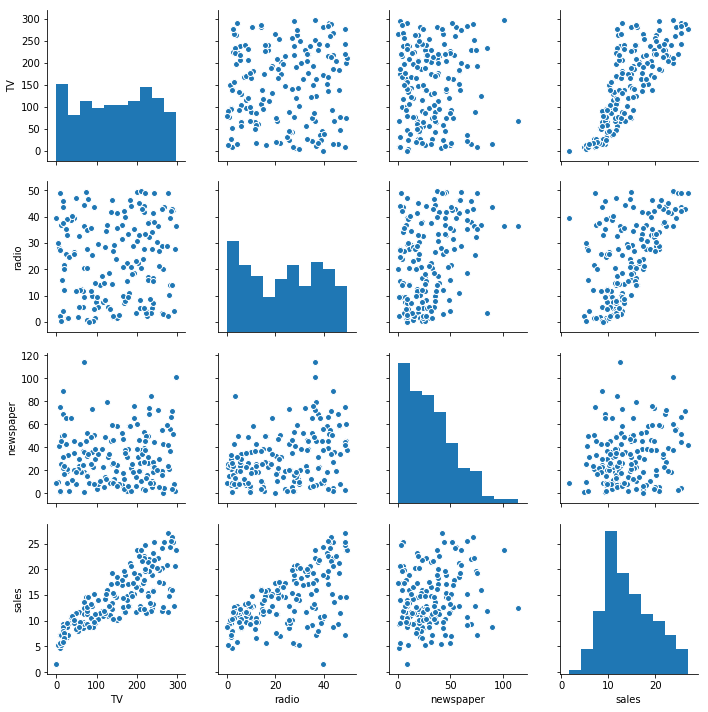

In [60]:
sampled_data = advt.select(numeric_features).sample(False, 0.8).toPandas()
sns.pairplot(sampled_data)

In [61]:
from pyspark.ml.stat import Correlation

In [62]:
advt.corr('TV','sales')

0.7822244248616067

In [63]:
import six
for i in advt.columns:
    if not( isinstance(advt.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to 'SALES' for ", i, advt.stat.corr('sales',i))

Correlation to 'SALES' for  TV 0.7822244248616067
Correlation to 'SALES' for  radio 0.5762225745710555
Correlation to 'SALES' for  newspaper 0.22829902637616545
Correlation to 'SALES' for  sales 1.0


In [64]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols=['TV', 'radio', 'newspaper'], outputCol='features')

In [65]:
vadvt_df = vectorAssembler.transform(advt)
vadvt_df = vadvt_df.select(['features', 'sales'])
vadvt_df.show(3,False)

+-----------------+-----+
|features         |sales|
+-----------------+-----+
|[230.1,37.8,69.2]|22.1 |
|[44.5,39.3,45.1] |10.4 |
|[17.2,45.9,69.3] |9.3  |
+-----------------+-----+
only showing top 3 rows



In [66]:
splits = vadvt_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [67]:
train_df.show(2)

+--------------+-----+
|      features|sales|
+--------------+-----+
|[0.7,39.6,8.7]|  1.6|
|[4.1,11.6,5.7]|  3.2|
+--------------+-----+
only showing top 2 rows



In [68]:
splits

[DataFrame[features: vector, sales: double],
 DataFrame[features: vector, sales: double]]

In [69]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='sales', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [70]:
lr_model = lr.fit(train_df)
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

Coefficients: [0.043327253564761685,0.1734293315315742,0.0]
Intercept: 3.6587717811708806


In [71]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 1.684645
r2: 0.894779


In [72]:
train_df.describe().show()

+-------+------------------+
|summary|             sales|
+-------+------------------+
|  count|               136|
|   mean|14.087500000000006|
| stddev| 5.212668862172873|
|    min|               1.6|
|    max|              26.2|
+-------+------------------+



In [73]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","sales","features").show(5)

+------------------+-----+----------------+
|        prediction|sales|        features|
+------------------+-----+----------------+
| 8.739998528773697|  5.7|  [8.4,27.2,2.1]|
| 4.395587758044137|  4.8|   [8.6,2.1,1.0]|
|12.516413199078285|  7.2| [8.7,48.9,75.0]|
| 10.56524298139368|  7.3|[11.7,36.9,45.2]|
|11.969864154345146|  8.7|[16.9,43.7,89.4]|
+------------------+-----+----------------+
only showing top 5 rows



In [74]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="sales",metricName="r2")

In [75]:
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.891122


In [76]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 1.72403


In [77]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","sales","features").show(5)

+------------------+-----+----------------+
|        prediction|sales|        features|
+------------------+-----+----------------+
| 8.739998528773697|  5.7|  [8.4,27.2,2.1]|
| 4.395587758044137|  4.8|   [8.6,2.1,1.0]|
|12.516413199078285|  7.2| [8.7,48.9,75.0]|
| 10.56524298139368|  7.3|[11.7,36.9,45.2]|
|11.969864154345146|  8.7|[16.9,43.7,89.4]|
+------------------+-----+----------------+
only showing top 5 rows



In [78]:
advt1 = advt.select('TV', 'radio', 'sales')

In [79]:
advt1.show(4)

+-----+-----+-----+
|   TV|radio|sales|
+-----+-----+-----+
|230.1| 37.8| 22.1|
| 44.5| 39.3| 10.4|
| 17.2| 45.9|  9.3|
|151.5| 41.3| 18.5|
+-----+-----+-----+
only showing top 4 rows



In [80]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols=['TV', 'radio'], outputCol='features')

In [81]:
vadvt_df = vectorAssembler.transform(advt1)
vadvt_df = vadvt_df.select(['features', 'sales'])
vadvt_df.show(3,False)

+------------+-----+
|features    |sales|
+------------+-----+
|[230.1,37.8]|22.1 |
|[44.5,39.3] |10.4 |
|[17.2,45.9] |9.3  |
+------------+-----+
only showing top 3 rows



In [82]:
splits = vadvt_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [83]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='sales', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))


Coefficients: [0.04212197464408384,0.181718138222043]
Intercept: 3.5954465277802523


In [84]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 1.713786
r2: 0.892482


In [85]:
train_df.describe().show()

+-------+------------------+
|summary|             sales|
+-------+------------------+
|  count|               136|
|   mean|14.534558823529418|
| stddev| 5.245871444415026|
|    min|               1.6|
|    max|              27.0|
+-------+------------------+



In [86]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","sales","features").show(5)

+------------------+-----+----------+
|        prediction|sales|  features|
+------------------+-----+----------+
| 5.876077027196695|  3.2|[4.1,11.6]|
| 9.009216626721471|  5.5|[7.3,28.1]|
|10.992833506841578|  6.6|[7.8,38.9]|
| 4.339303599985664|  4.8| [8.6,2.1]|
|12.847924666241685|  7.2|[8.7,48.9]|
+------------------+-----+----------+
only showing top 5 rows



In [87]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="sales",metricName="r2")

In [88]:
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.887339


In [89]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 1.67332


In [90]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","sales","features").show(5)

+------------------+-----+----------+
|        prediction|sales|  features|
+------------------+-----+----------+
| 5.876077027196695|  3.2|[4.1,11.6]|
| 9.009216626721471|  5.5|[7.3,28.1]|
|10.992833506841578|  6.6|[7.8,38.9]|
| 4.339303599985664|  4.8| [8.6,2.1]|
|12.847924666241685|  7.2|[8.7,48.9]|
+------------------+-----+----------+
only showing top 5 rows



# Boston housing price prediction

In [94]:
import pyspark
from pyspark import SparkConf,SparkContext
from pyspark.sql import *
spark = sqlContext

In [97]:
import os
import tarfile
from  six.moves import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL,housing_path = HOUSING_PATH ) :
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [98]:
fetch_housing_data()

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [99]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(csv_path)

In [100]:
housing = load_housing_data()
housing.show(4)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
+---------+--------+--------------

In [102]:
housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [103]:
housing.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

In [104]:
housing.describe(['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']).show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|
| stddev|  2.003531723502584|2.135952397457101| 12.58555761211163|2181.6152515827944|421.38507007403

In [105]:
housing.select("ocean_proximity").distinct().show()

+---------------+
|ocean_proximity|
+---------------+
|         ISLAND|
|     NEAR OCEAN|
|       NEAR BAY|
|      <1H OCEAN|
|         INLAND|
+---------------+



In [106]:
housing.select("ocean_proximity").groupBy('ocean_proximity').count().show()

+---------------+-----+
|ocean_proximity|count|
+---------------+-----+
|         ISLAND|    5|
|     NEAR OCEAN| 2658|
|       NEAR BAY| 2290|
|      <1H OCEAN| 9136|
|         INLAND| 6551|
+---------------+-----+



In [107]:
housing.cache()

DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, median_house_value: double, ocean_proximity: string]

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
housing.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'double'),
 ('total_rooms', 'double'),
 ('total_bedrooms', 'double'),
 ('population', 'double'),
 ('households', 'double'),
 ('median_income', 'double'),
 ('median_house_value', 'double'),
 ('ocean_proximity', 'string')]

In [110]:
from pyspark.ml.stat import Correlation
import math
from pyspark.sql.functions import *

In [111]:
import six
for i in housing.columns:
    if not( isinstance(housing.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to median_house_value for ", i, housing.stat.corr('median_house_value',i))

Correlation to median_house_value for  longitude -0.045966615117981745
Correlation to median_house_value for  latitude -0.14416027687465752
Correlation to median_house_value for  housing_median_age 0.10562341249321067
Correlation to median_house_value for  total_rooms 0.13415311380656275
Correlation to median_house_value for  total_bedrooms 0.04914821959942553
Correlation to median_house_value for  population -0.024649678888894876
Correlation to median_house_value for  households 0.06584265057005637
Correlation to median_house_value for  median_income 0.6880752079585578
Correlation to median_house_value for  median_house_value 1.0


In [112]:
housing1 = housing.withColumn('income_cat',ceil(col('median_income')/1.5))

In [113]:
housing1.show(4)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|income_cat|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|         6|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|         6|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|         5|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|    

In [114]:
housing1 = housing1.withColumn("income_cat",when(col('income_cat') > 5,5).otherwise(col('income_cat')))

In [115]:
housing1.select("income_cat").distinct().show()

+----------+
|income_cat|
+----------+
|         5|
|         1|
|         3|
|         2|
|         4|
+----------+



In [116]:
housing1.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'income_cat']

In [117]:
housing = housing1.select('longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
  'median_house_value',
 'ocean_proximity',
 'income_cat')

In [118]:
housing.show(4)

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+---------------+----------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_house_value|ocean_proximity|income_cat|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+---------------+----------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|          452600.0|       NEAR BAY|         5|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|          358500.0|       NEAR BAY|         5|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|          352100.0|       NEAR BAY|         5|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|          341300.0|       NEAR BAY|         4|
+---------+--------+------------------+-----------+----

In [119]:
cat_data = housing.select("ocean_proximity")

In [120]:
cat_data.distinct().show()

+---------------+
|ocean_proximity|
+---------------+
|         ISLAND|
|     NEAR OCEAN|
|       NEAR BAY|
|      <1H OCEAN|
|         INLAND|
+---------------+



In [121]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximityIndex")

In [122]:
indexed = indexer.fit(cat_data).transform(cat_data)
indexed.distinct().show()

+---------------+--------------------+
|ocean_proximity|ocean_proximityIndex|
+---------------+--------------------+
|         INLAND|                 1.0|
|     NEAR OCEAN|                 2.0|
|       NEAR BAY|                 3.0|
|         ISLAND|                 4.0|
|      <1H OCEAN|                 0.0|
+---------------+--------------------+



In [123]:
oceanlevel = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_level")
housing_indexed = oceanlevel.fit(housing).transform(housing)
housing_indexed.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+---------------+----------+-----------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_house_value|ocean_proximity|income_cat|ocean_level|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+---------------+----------+-----------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|          452600.0|       NEAR BAY|         5|        3.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|          358500.0|       NEAR BAY|         5|        3.0|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|          352100.0|       NEAR BAY|         5|        3.0|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+-----------

In [124]:
housing_indexed.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_house_value',
 'ocean_proximity',
 'income_cat',
 'ocean_level']

In [125]:
housing = housing_indexed.select('longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_house_value',
 'income_cat',
 'ocean_level')

In [126]:
housing.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|median_house_value|       income_cat|       ocean_level|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|            20640|             20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|206855.81690891474|3.006686046511628|0.9087693798449612|
| stddev| 

In [127]:
from pyspark.ml.feature import Imputer

In [128]:
imputer = Imputer(strategy='median',inputCols= ['total_bedrooms'], outputCols=["total_bedrooms_a"])
house_impu = imputer.fit(housing).transform(housing)
house_impu.show(2)

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+----------+-----------+----------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_house_value|income_cat|ocean_level|total_bedrooms_a|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+----------+-----------+----------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|          452600.0|         5|        3.0|           129.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|          358500.0|         5|        3.0|          1106.0|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+----------+-----------+----------------+
only showing top 2 rows



In [129]:
house_impu.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_house_value',
 'income_cat',
 'ocean_level',
 'total_bedrooms_a']

In [130]:
housing = house_impu.select('longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
  'population',
 'households',
 'median_house_value',
 'income_cat',
 'ocean_level',
 'total_bedrooms_a')

In [131]:
housing = housing.withColumnRenamed('total_bedrooms_a','total_bedrooms')

In [132]:
housing.describe().show(4)

+-------+-------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|        population|       households|median_house_value|       income_cat|       ocean_level|    total_bedrooms|
+-------+-------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|  count|              20640|            20640|             20640|             20640|             20640|            20640|             20640|            20640|             20640|             20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488|1425.4767441860465|499.5396802325581|206855.81690891474|3.006686046511628|0.9087693798449612| 536.8388565891473|
| stddev| 

In [133]:
housing.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'population',
 'households',
 'median_house_value',
 'income_cat',
 'ocean_level',
 'total_bedrooms']

In [134]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols=['longitude', 'latitude', 'housing_median_age','total_rooms','population','households', 'income_cat', 'ocean_level','total_bedrooms'], outputCol='features', handleInvalid='error')

In [136]:
vhouse_df = vectorAssembler.transform(housing)
vhouse_df = vhouse_df.select(['features', 'median_house_value'])
vhouse_df.show(3,False)

+--------------------------------------------------------+------------------+
|features                                                |median_house_value|
+--------------------------------------------------------+------------------+
|[-122.23,37.88,41.0,880.0,322.0,126.0,5.0,3.0,129.0]    |452600.0          |
|[-122.22,37.86,21.0,7099.0,2401.0,1138.0,5.0,3.0,1106.0]|358500.0          |
|[-122.24,37.85,52.0,1467.0,496.0,177.0,5.0,3.0,190.0]   |352100.0          |
+--------------------------------------------------------+------------------+
only showing top 3 rows



In [141]:
split = vhouse_df.randomSplit([0.7, 0.3],seed =42)
train_housing = split[0]
test_houing = split[1]
from pyspark.ml.regression import LinearRegression


In [143]:
print(train_housing.count())
print(test_houing.count())

14476
6164


In [144]:
train_housing.show(3)

+--------------------+------------------+
|            features|median_house_value|
+--------------------+------------------+
|[-124.35,40.54,52...|           94600.0|
|[-124.26,40.58,52...|          111400.0|
|[-124.25,40.28,32...|           76100.0|
+--------------------+------------------+
only showing top 3 rows



In [146]:
lr = LinearRegression(featuresCol='features', labelCol='median_house_value', maxIter=10, regParam=0.3, elasticNetParam=0.8, loss='squaredError')
lr_model = lr.fit(train_housing)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


Coefficients: [-35226.796299014284,-36848.637634477636,1160.8501201641009,-1.7876107681803743,-41.922590651361226,78.12998242904858,67806.12348718701,-606.0198735471689,65.79908423760918]
Intercept: -2938821.8237943817


In [147]:
trainingSummary = lr_model.summary
print("RMS error",trainingSummary.rootMeanSquaredError)
print("r2",trainingSummary.r2)

RMS error 75183.43698632048
r2 0.5798054960420443


In [149]:
train_housing.describe().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|             14476|
|   mean|207302.12655429676|
| stddev|115987.71497356692|
|    min|           14999.0|
|    max|          500001.0|
+-------+------------------+



In [151]:
lr_predictions = lr_model.transform(test_houing)
lr_predictions.select("prediction","median_house_value","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="median_house_value",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------------------+--------------------+
|        prediction|median_house_value|            features|
+------------------+------------------+--------------------+
| 70527.47002452752|           85800.0|[-124.3,41.8,19.0...|
|133692.18922491092|          103600.0|[-124.3,41.84,17....|
| 132449.5858652005|           79000.0|[-124.27,40.69,36...|
|175111.73010426527|           90100.0|[-124.19,40.73,21...|
| 70678.86270813644|           74600.0|[-124.19,41.78,15...|
+------------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.566048


In [152]:
test_result = lr_model.evaluate(test_houing)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 75088.5


In [153]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5, 0.4332006185897801, 0.2871931136761818, 0.2516133458385103, 0.24094152356958828, 0.23351286602298899, 0.21746814703803857, 0.21521212811678617, 0.2131330744540496, 0.21132659848525906, 0.21010383663470258]
+-------------------+
|          residuals|
+-------------------+
|  -119548.824113362|
| -39274.46250194032|
| -70721.33878251677|
|-110112.72736986727|
|-147777.36862702947|
| 11050.586445772555|
| -15463.85414912505|
|  -63112.9880278958|
| -6738.209328714758|
|  6487.557631603908|
| -58540.83876178367|
| -52680.65844285954|
| -78559.01971007371|
| -37083.94297605893|
| -45869.14282683516|
| -44661.10125029413|
|  -50950.5542352451|
| 12258.400938061532|
| -33170.55700143054|
| -33591.41210049158|
+-------------------+
only showing top 20 rows



In [156]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol='features', labelCol='median_house_value', predictionCol='prediction', maxDepth=10, maxBins=32,seed=42)

In [157]:
dt_model = dt.fit(train_housing)
dt_predictions = dt_model.transform(test_houing)
dt_evaluator = RegressionEvaluator(
    labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 63443.4


In [158]:
dt_predictions = dt_model.transform(test_houing)
dt_predictions.select("prediction","median_house_value","features").show(5)

+------------------+------------------+--------------------+
|        prediction|median_house_value|            features|
+------------------+------------------+--------------------+
|101382.60869565218|           85800.0|[-124.3,41.8,19.0...|
| 150214.2857142857|          103600.0|[-124.3,41.84,17....|
| 75723.33333333333|           79000.0|[-124.27,40.69,36...|
|          140500.0|           90100.0|[-124.19,40.73,21...|
|101382.60869565218|           74600.0|[-124.19,41.78,15...|
+------------------+------------------+--------------------+
only showing top 5 rows



In [159]:
dt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="median_house_value",metricName="r2")
print("R Squared (R2) on test data = %g" % dt_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.566048


In [160]:
dt_model.featureImportances

SparseVector(9, {0: 0.1045, 1: 0.0969, 2: 0.0544, 3: 0.0191, 4: 0.0093, 5: 0.0047, 6: 0.5238, 7: 0.1813, 8: 0.0059})

In [161]:
housing.take(1)

[Row(longitude=-122.23, latitude=37.88, housing_median_age=41.0, total_rooms=880.0, population=322.0, households=126.0, median_house_value=452600.0, income_cat=5, ocean_level=3.0, total_bedrooms=129.0)]

In [163]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'median_house_value', maxIter=100)
gbt_model = gbt.fit(train_housing)
gbt_predictions = gbt_model.transform(test_houing)
gbt_predictions.select('prediction', 'median_house_value', 'features').show(5)

+------------------+------------------+--------------------+
|        prediction|median_house_value|            features|
+------------------+------------------+--------------------+
| 93516.16538285019|           85800.0|[-124.3,41.8,19.0...|
|115499.76717329137|          103600.0|[-124.3,41.84,17....|
| 81316.17862622005|           79000.0|[-124.27,40.69,36...|
|119535.07853329895|           90100.0|[-124.19,40.73,21...|
|  71656.8127292084|           74600.0|[-124.19,41.78,15...|
+------------------+------------------+--------------------+
only showing top 5 rows



In [164]:
gbt_evaluator = RegressionEvaluator(
    labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 52416.3
